In [1]:
import torch
import numpy as np
import torchvision.utils as vutils
import torchvision.datasets as vds
import torchvision.transforms as transforms
import torch.optim as optim

import os
import matplotlib.pyplot as plt
import PIL.Image
import datetime

In [2]:
date = datetime.date.today()
lr = 1e-6
beta1 = 0.5
gamma=10.0
batch_size = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
date

datetime.date(2022, 7, 22)

In [4]:
model_path = './export_model/'
G = torch.load(model_path+'generator.pth').to(device)
D = torch.load(model_path+'discriminator.pth').to(device)
G_ema = torch.load(model_path+'gen_ema.pth').to(device)

In [5]:
dataroot = '../../dataset/'
dataset = vds.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                              transforms.Resize((1024,512)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))
flip_dataset = vds.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                              transforms.Resize((1024,512)),
                              transforms.RandomHorizontalFlip(p=1),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))
merge_dataset = torch.utils.data.ConcatDataset([dataset,flip_dataset])
dataloader = torch.utils.data.DataLoader(merge_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)


In [6]:
len(dataloader)

173

In [7]:
optimizerD = optim.SGD(D.parameters(), lr=lr, momentum=0.9)
optimizerG = optim.SGD(G.parameters(), lr=lr, momentum=0.9)
# optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
torch.cuda.empty_cache()
num_epochs = 100

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
best_vloss = 1_000_000.

fixed_noise = torch.from_numpy(
    np.random.RandomState(999).randn(1, G.z_dim)
).to(device)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        label = torch.zeros([1, G.c_dim], device=device)
        z = torch.from_numpy(np.random.RandomState().randn(1, G.z_dim)).to(device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.train(True)
        D.requires_grad_(True)
        
        D.zero_grad()
        optimizerD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        # Forward pass real batch through D
        real_score = D(real_cpu,label).view(-1)
        # Calculate loss on all-real batch
        errD_real = torch.nn.Softplus()(-real_score) # -log(sigmoid(real_scores_out)) # pylint: disable=invalid-unary-operand-type


        # Calculate gradients for D in backward pass
        D_x = real_score.mean().item()

        ## Train with all-fake batch
        # Generate fake image batch with G
        fake = G(z,label)
        # Classify all fake batch with D
        fake_score = D(fake.detach(),label).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = torch.nn.Softplus()(fake_score)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        D_G_z1 = -fake_score.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = (errD_real + errD_fake).mean()
        errD.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.train(True)
        G.requires_grad_(True)
        
        optimizerG.zero_grad()
        G.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_score = D(fake, label).view(-1)
        # Calculate G's loss based on this output
        errG = torch.nn.Softplus()(-fake_score) # -log(sigmoid(fake_scores_out))
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = -fake_score.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            history = '[%02d/%02d][%02d/%02d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'%(
                epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2
            )
            print(history)
            if not os.path.exists('./logs'):
                os.mkdir('./logs')

            with open('./logs/{0:%Y-%m-%d}_option_{1}-{2}.txt'.format(
                date, 'batch_size', batch_size
            ),'a+',encoding='utf8') as f:
                f.write(history+'\n')
            
            if errG < best_vloss:
                best_vloss = errG.item()
                if not os.path.exists('./checkpoint'):
                    os.mkdir('./checkpoint')
                    
                Gmodel_path = './checkpoint/Gmodel_{:03d}_{:0.2f}.pth'.format(
                    epoch, best_vloss)
                Dmodel_path = './checkpoint/Dmodel_{:03d}_{:0.2f}.pth'.format(
                    epoch, best_vloss)
                torch.save(G, Gmodel_path)
                torch.save(D, Dmodel_path)

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise,label).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
#             PIL.Image.fromarray(
#                 np.transpose(img_list[-1].numpy(), (1,2,0)), 
#                 'RGB'
#             ).save(f'outputs/{epoch}-{i}.png')
        iters += 1

Starting Training Loop...
[00/100][00/173] Loss_D: 2.0575 Loss_G: 10.3803 D(x): -1.9090 D(G(z)): 10.3809 / 10.3803
[00/100][50/173] Loss_D: 2.1910 Loss_G: 9.6975 D(x): -2.0679 D(G(z)): 9.7000 / 9.6974
[00/100][100/173] Loss_D: 1.9664 Loss_G: 8.8415 D(x): -1.7879 D(G(z)): 8.8421 / 8.8414
[00/100][150/173] Loss_D: 1.5851 Loss_G: 6.7657 D(x): -1.3493 D(G(z)): 6.7566 / 6.7645
[01/100][00/173] Loss_D: 1.4802 Loss_G: 7.7144 D(x): -1.1843 D(G(z)): 7.7172 / 7.7140
[01/100][50/173] Loss_D: 1.9066 Loss_G: 7.3368 D(x): -1.7396 D(G(z)): 7.3384 / 7.3362
[01/100][100/173] Loss_D: 1.5393 Loss_G: 6.4669 D(x): -1.2841 D(G(z)): 6.4699 / 6.4654
[01/100][150/173] Loss_D: 1.7039 Loss_G: 6.7263 D(x): -1.4630 D(G(z)): 6.7371 / 6.7251
[02/100][00/173] Loss_D: 1.8268 Loss_G: 8.1257 D(x): -1.6444 D(G(z)): 8.1271 / 8.1254
[02/100][50/173] Loss_D: 1.3146 Loss_G: 6.6396 D(x): -0.9704 D(G(z)): 6.6416 / 6.6383
[02/100][100/173] Loss_D: 1.2233 Loss_G: 7.2178 D(x): -0.8642 D(G(z)): 7.2193 / 7.2171
[02/100][150/173] Lo

[24/100][00/173] Loss_D: 0.4096 Loss_G: 2.2290 D(x): 1.1239 D(G(z)): 2.1237 / 2.1151
[24/100][50/173] Loss_D: 0.5600 Loss_G: 2.2821 D(x): 0.5666 D(G(z)): 2.1742 / 2.1744
[24/100][100/173] Loss_D: 0.4802 Loss_G: 2.0079 D(x): 0.9422 D(G(z)): 1.8636 / 1.8637
[24/100][150/173] Loss_D: 0.5123 Loss_G: 2.4214 D(x): 0.6970 D(G(z)): 2.3286 / 2.3284
[25/100][00/173] Loss_D: 0.4667 Loss_G: 2.5272 D(x): 0.7950 D(G(z)): 2.4395 / 2.4439
[25/100][50/173] Loss_D: 0.4099 Loss_G: 2.3526 D(x): 1.0571 D(G(z)): 2.2532 / 2.2527
[25/100][100/173] Loss_D: 0.3822 Loss_G: 1.9901 D(x): 1.3394 D(G(z)): 1.8426 / 1.8431
[25/100][150/173] Loss_D: 0.4362 Loss_G: 2.7970 D(x): 0.8098 D(G(z)): 2.7341 / 2.7340
[26/100][00/173] Loss_D: 0.4486 Loss_G: 1.7263 D(x): 1.3076 D(G(z)): 1.5296 / 1.5303
[26/100][50/173] Loss_D: 0.4290 Loss_G: 2.4205 D(x): 0.9445 D(G(z)): 2.3274 / 2.3274
[26/100][100/173] Loss_D: 0.4183 Loss_G: 2.5040 D(x): 0.9628 D(G(z)): 2.4122 / 2.4187
[26/100][150/173] Loss_D: 0.4235 Loss_G: 2.0969 D(x): 1.1267

[48/100][00/173] Loss_D: 0.3142 Loss_G: 2.4108 D(x): 1.4135 D(G(z)): 2.3165 / 2.3167
[48/100][50/173] Loss_D: 0.4182 Loss_G: 3.2416 D(x): 0.8159 D(G(z)): 3.2020 / 3.2017
[48/100][100/173] Loss_D: 0.4493 Loss_G: 2.2600 D(x): 0.9236 D(G(z)): 2.1505 / 2.1498
[48/100][150/173] Loss_D: 0.3661 Loss_G: 2.3683 D(x): 1.1979 D(G(z)): 2.2676 / 2.2700
[49/100][00/173] Loss_D: 0.3123 Loss_G: 2.1502 D(x): 1.6225 D(G(z)): 2.0265 / 2.0264
[49/100][50/173] Loss_D: 0.4004 Loss_G: 2.0591 D(x): 1.2249 D(G(z)): 1.9218 / 1.9226
[49/100][100/173] Loss_D: 0.4244 Loss_G: 2.5390 D(x): 0.9051 D(G(z)): 2.4527 / 2.4568
[49/100][150/173] Loss_D: 0.2877 Loss_G: 2.4618 D(x): 1.5498 D(G(z)): 2.3719 / 2.3726
[50/100][00/173] Loss_D: 0.5595 Loss_G: 2.0958 D(x): 0.7596 D(G(z)): 1.9639 / 1.9646
[50/100][50/173] Loss_D: 0.3955 Loss_G: 2.4892 D(x): 1.0202 D(G(z)): 2.4038 / 2.4026
[50/100][100/173] Loss_D: 0.4944 Loss_G: 2.1087 D(x): 0.8556 D(G(z)): 1.9787 / 1.9793
[50/100][150/173] Loss_D: 0.4180 Loss_G: 1.9128 D(x): 1.2490

[72/100][00/173] Loss_D: 0.3317 Loss_G: 2.2350 D(x): 1.4374 D(G(z)): 2.1206 / 2.1219
[72/100][50/173] Loss_D: 0.3711 Loss_G: 2.1012 D(x): 1.3296 D(G(z)): 1.9703 / 1.9707
[72/100][100/173] Loss_D: 0.4809 Loss_G: 2.0463 D(x): 0.9383 D(G(z)): 1.9060 / 1.9079
[72/100][150/173] Loss_D: 0.2758 Loss_G: 2.4209 D(x): 1.6113 D(G(z)): 2.3286 / 2.3279
[73/100][00/173] Loss_D: 0.3862 Loss_G: 2.2287 D(x): 1.1694 D(G(z)): 2.1149 / 2.1148
[73/100][50/173] Loss_D: 0.2426 Loss_G: 3.1644 D(x): 1.5314 D(G(z)): 3.1211 / 3.1212
[73/100][100/173] Loss_D: 0.3516 Loss_G: 2.3765 D(x): 1.2567 D(G(z)): 2.2711 / 2.2790
[73/100][150/173] Loss_D: 0.3025 Loss_G: 2.7820 D(x): 1.3150 D(G(z)): 2.7222 / 2.7181
[74/100][00/173] Loss_D: 0.3412 Loss_G: 2.5263 D(x): 1.2982 D(G(z)): 2.4429 / 2.4429
[74/100][50/173] Loss_D: 0.3395 Loss_G: 2.3195 D(x): 1.3429 D(G(z)): 2.2165 / 2.2160
[74/100][100/173] Loss_D: 0.3659 Loss_G: 2.6040 D(x): 1.1181 D(G(z)): 2.5275 / 2.5271
[74/100][150/173] Loss_D: 0.3466 Loss_G: 2.2813 D(x): 1.3302

[96/100][00/173] Loss_D: 0.3353 Loss_G: 2.3571 D(x): 1.3571 D(G(z)): 2.2579 / 2.2576
[96/100][50/173] Loss_D: 0.3321 Loss_G: 2.3747 D(x): 1.3528 D(G(z)): 2.2768 / 2.2770
[96/100][100/173] Loss_D: 0.3280 Loss_G: 2.1344 D(x): 1.5169 D(G(z)): 2.0041 / 2.0085
[96/100][150/173] Loss_D: 0.4264 Loss_G: 2.7935 D(x): 0.9115 D(G(z)): 2.7302 / 2.7303
[97/100][00/173] Loss_D: 0.3068 Loss_G: 2.2983 D(x): 1.5101 D(G(z)): 2.1924 / 2.1925
[97/100][50/173] Loss_D: 0.2096 Loss_G: 2.6849 D(x): 2.0996 D(G(z)): 2.6133 / 2.6142
[97/100][100/173] Loss_D: 0.3426 Loss_G: 2.3048 D(x): 1.3248 D(G(z)): 2.1983 / 2.1997
[97/100][150/173] Loss_D: 0.3145 Loss_G: 2.4817 D(x): 1.3856 D(G(z)): 2.3952 / 2.3944
[98/100][00/173] Loss_D: 0.3163 Loss_G: 2.3326 D(x): 1.4447 D(G(z)): 2.2315 / 2.2305
[98/100][50/173] Loss_D: 0.2664 Loss_G: 2.2510 D(x): 1.8023 D(G(z)): 2.1393 / 2.1397
[98/100][100/173] Loss_D: 0.3566 Loss_G: 2.4799 D(x): 1.1939 D(G(z)): 2.3940 / 2.3925
[98/100][150/173] Loss_D: 0.3133 Loss_G: 2.3710 D(x): 1.4461

In [10]:
Gmodel_path = './checkpoint/Gmodel_last.pth'
Dmodel_path = './checkpoint/Dmodel_last.pth'
torch.save(G, Gmodel_path)
torch.save(D, Dmodel_path)

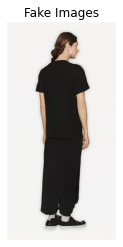

In [11]:
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()